# Subreddit Predictor

The purpose of this project is to create a Machine Learning Model which can read a reddit post title and predict which subreddit it belongs to. The project will be broken up into steps which can be separated into three main sections.

### First Look
1: Identify the Problem and Goal
2: Aquire the Data
3: Analyze the Data
4: Naive Model
5: Speculate on Model Improvements

### Systematic Approach
6: Create New Models
7: Compare and Analyze Results
8: Choose a "Winning" Model

### Optimization
9: optimize the Winning Model
10: Analyze Final Results
11: Suggest Future Improvements

# 1: Identify the Problem

The purpose of this project is to create a Machine Learning model which can read a reddit post title and predict which subreddit it belongs to. For simplicity we will train the model only to distinguish between a small number of subreddits. These subreddits are chosen to have a wide variety of post titles. Some subreddits will be trivial for the model, such as r/AmITheAsshole in which every post contains the word "AITA" or "WIBTA", abriviations for "Am I the asshole" and "Would I be the asshole" respectively. Other subreddits such as r/Awww and r/pics have post titles which contain very little information and thus will most likely be hard to distinguish.

In [1]:
top_subreddits = ['announcements', 'funny', 'AskReddit', 'dataisbeautiful', 'Awww', 'datascience', 'pics', 'science', 'worldnews', 'videos', 'AmItheAsshole']

### Metrics

The overall metric for each model will be Accuracy = Correct_Classifiactions/All_Classifications. However we expect any model will preform differently on different subreddits. So we want to measure the contrubution to the accuracy score from each subreddit. Fortunately this coincides with the Recall = True_Positives/(True_Positives + False_Negatives) when the saize of each categories are the same.



# 2: Aquire and Pre-Clean the Data

Reddit data is usually gathered through an API and by using the wrapper "praw". For larger amounts of data, or for historical data we can use PushShift and it's wrapper "psaw". Unfortunately, PushShift is down right now so we will have to stick with "praw". This limits the amount of data we can gather. We will limit ourselves to the last 1000 posts on each subreddit.

In [2]:
import praw
import secrets

user_agent = "Subreddit-Predictor 0.2 by /u/IsThisATrollBot"

reddit = praw.Reddit(
    client_id=secrets.client_ID,
    client_secret=secrets.client_secret,
    password=secrets.password,
    user_agent=user_agent,
    username=secrets.username,
)

In [3]:
from tqdm import tqdm

# Create an empty list to store the posts
posts = []

# Iterate through the subreddits and get the last 1000 posts from each
for sub in tqdm(top_subreddits):
    subreddit_posts = reddit.subreddit(sub).new(limit=1000)
    for post in subreddit_posts:
        posts.append(post)

100%|██████████| 11/11 [02:10<00:00, 11.84s/it]


In [4]:
import pandas as pd

# Create a list of dictionaries containing the data for each post
data = [{'id': post.id, 'title': post.title, 'subreddit': post.subreddit.display_name} for post in posts]

# Create a Pandas dataframe from the list of dictionaries
df_raw = pd.DataFrame(data)
df_raw = df_raw.set_index('id')

## Remove Empty and Repeated entires

In [5]:
df = df_raw.copy()

# Remove empty rows
df['title'] = df['title'].str.strip()
filter = df['title'] == ''
print(len(df[filter]))
df = df.drop(df[filter].index)

0


In [6]:
# Find any duplicates
df[df.duplicated(keep = False)]

,title,subreddit
id,,
c0gmy,"We are aware that reddit appears hung over, an...",announcements
c0gl6,"We are aware that reddit appears hung over, an...",announcements
10nz8x0,My small town is having a telethon. This is fr...,funny
10ny2m3,My small town is having a telethon. This is fr...,funny
10q8j2r,What screams rich pretending to be poor?,AskReddit
...,...,...
10ori9a,BLINKED OUT SPACE ADVENTURES - WE LIT,videos
10oqrcf,BLINKED OUT SPACE ADVENTURES - WE LIT,videos
10ohcvd,MASTERING THE ART OF PERSUASION,videos


In [7]:
# Drop the duplicates
filter = df.duplicated()
df = df[~filter]
df

,title,subreddit
id,,
t93ec3,This subreddit is closed for new posts and com...,announcements
pg006s,COVID denialism and policy clarifications,announcements
pbmy5y,"Debate, dissent, and protest on Reddit",announcements
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
mi01fg,Second,announcements
...,...,...
10mvmxu,WIBTA if I planned and threw a St. Patty’s par...,AmItheAsshole
10mvlnr,AITA for lashing out at my parents?,AmItheAsshole
10mvlgl,AITA for not wanting to spend time with my wif...,AmItheAsshole


# 3: Inspect the Data by Hand

Let's first read through a couple entries, then clear out all of the empty and duplicate rows. After that we are going to examine a large number of entries and see if we can classify them **by hand**. This will give us a good benchmark on how difficult the problem is. It will also give incite into which features will be most useful.

In [8]:
df

,title,subreddit
id,,
t93ec3,This subreddit is closed for new posts and com...,announcements
pg006s,COVID denialism and policy clarifications,announcements
pbmy5y,"Debate, dissent, and protest on Reddit",announcements
nw2hs6,Sunsetting Secret Santa and Reddit Gifts,announcements
mi01fg,Second,announcements
...,...,...
10mvmxu,WIBTA if I planned and threw a St. Patty’s par...,AmItheAsshole
10mvlnr,AITA for lashing out at my parents?,AmItheAsshole
10mvlgl,AITA for not wanting to spend time with my wif...,AmItheAsshole


### Load the Human Data

I have already examined the data and attempted to assign to each post title a subreddit from the list of top_subreddits. The data set I looked at consisted of 20 random samples from each subreddit, so 220 samples in total. I also wrote down the explanation of each decision to gather further insight.

In [9]:
human = pd.read_csv('human.csv')
human = human.set_index('id')
human

,title,actual,prediction,explanation
id,,,,
10jo7ai,Why Thou At The Airport,videos,videos,asks a question in a weird way
10dxjxk,"""Did I promise to show you lovely patients? Lo...",Awww,Awww,"""lovely"" and ""look"""
3p4shh,CEO Steve here to answer more questions.,announcements,announcements,sounds like buisness stuff
10jpv7y,Saw this on an old mini van's windows there we...,pics,funny,referencing a picture that might be funny
10gy5x1,UK shop sales fell by record numbers both in D...,worldnews,worldnews,sounds like news
...,...,...,...,...
cskdl,"Welcome, Jeff!",announcements,funny,probably a funny picture
10i2tcg,Random click,pics,funny,probably a funny pic or video
10jqv4f,Serbia May Lose Chance to Join EU If It Reject...,worldnews,worldnews,countries


Even without doing an indepth analysis a few things are immediatly clear:
- Certain "key words" belong exclusively to certain subreddits. These words are ['aita', 'wibta', '[oc]', '[serious]', 'data scientist']. More words probably exist.
- If the post asks a question, it is usually either AskReddit or datascience. Specific questions are datascience and general ones are AskReddit.
- r/science has a lot of science-y words.
- r/worldnews has long titles and usually contains country names
- "cute" words like ['puppy', 'baby', '<3'] indicate r/Awww
- A lot of the subreddits were distinguished by what topic the post titles were talking about. This probably means a pre-trained Word2Vec model (maybe averaging word vectors) could be useful.
- Emojis and shorter titles are more appropriate in r/Awww and r/funny
- r/videos is very difficult to deal with.

### Data Visualization

Let's now do an analysis to show the recall score for each subreddit category.

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
human_prediction_data = pd.DataFrame(columns=['value'])
human_bar_data = {}
for sub in top_subreddits:
    filter1 = human['actual'] == sub
    filter2 = human['actual'] == human['prediction']
    #human_prediction_data.loc[sub] = len(human[filter1 & filter2])/20
    human_bar_data[sub] = len(human[filter1 & filter2])/20

human_bar_data['Total'] = sum(list(human_bar_data.values()))/len(top_subreddits)

In [25]:
# Save the data for later use

import pickle as pkl

with open("human_results.pkl", 'wb') as f:
    pkl.dump(human_bar_data, f)


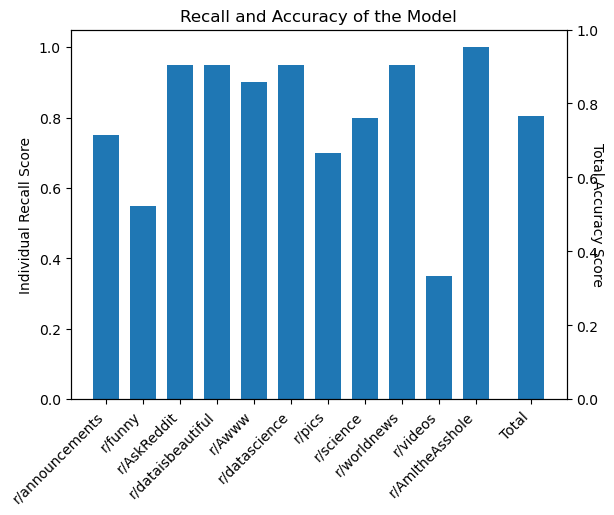

In [12]:
# Create a Bar Chart

categories = list(human_bar_data.keys())
for i, cat in list(enumerate(categories))[:-1]:
    categories[i] = 'r/' + cat

xticks = list(range(len(categories)))
xticks[-1] += .5
xticks = np.array(xticks)

bar_width = 0.7

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

#ax1.bar(xticks - 0.2, naive_bar_data.values(), bar_width, label='Naive Model')
ax1.bar(xticks, human_bar_data.values(), bar_width)

# Add error bars to the 'Naive Model' set of bars
#Naive_Error = [0.1, 0.15, 0.2, 0.05, 0.1, .1, .3, .05, .2, .1, .11, .15] # Example values
#ax1.errorbar(xticks - 0.2, naive_bar_data.values(), yerr=naive_results_95_error, fmt='none', ecolor='gray', elinewidth=2, capsize=5)

ax1.set_xticks(xticks)
ax1.set_xticklabels(categories, rotation=45, ha='right')

plt.xlabel("Subreddits")
ax1.set_ylabel("Individual Recall Score")
ax2.set_ylabel("Total Accuracy Score", rotation=-90)
plt.title("Recall and Accuracy of the Model")
#ax1.legend()
plt.show()






Seeing the actual recall scores confirms the initial assessment

# 4: Initial Feature Analysis

We're now going to analyize a few features to confirm that they will actually be useful in classification.

## Length of Post

How much does the length of a post title tell us about the subreddit? To answer this question we will create a line graph with a serperate line for each subreddit. The x-axis is the length of the post and the y-axis is the percentage of all the subreddit post titles that are of that length (so the total area under each curve should be 1). If a specific line is visible at a certain x value, then this tells us post titles of that length will be more or less likely to come from that specific subreddit.

We will create theis graph using two different ways of computing length: number of words and number of characters.

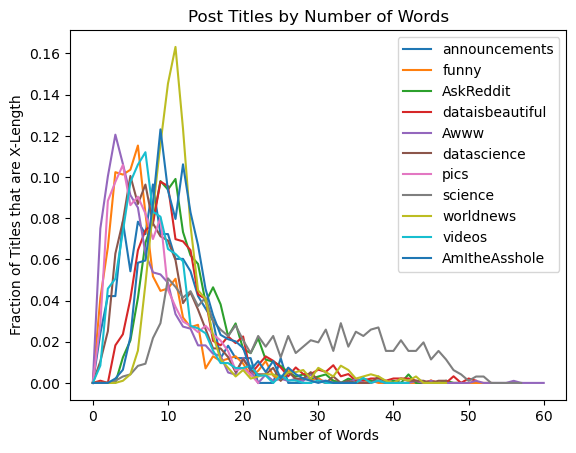

In [13]:
import matplotlib.pyplot as plt

# Initialize an empty dictionary to store the data
data = {}

# Iterate over the top_subreddits
for subreddit in top_subreddits:
    # Get the titles for the subreddit
    titles = df_raw[df_raw['subreddit'] == subreddit]['title']
    # Get the number of words in the titles
    num_words = [len(title.split()) for title in titles]
    # Get the percentage of titles for the subreddit with a specific number of words
    percentages = []
    for i in range(max(num_words)):
        percentages.append(num_words.count(i)/len(num_words))
    # Add the data to the dictionary
    data[subreddit] = percentages

# Plot the data
for subreddit, percentages in data.items():
    plt.plot(range(len(percentages)), percentages, label=subreddit)

# Add labels and title
plt.xlabel("Number of Words")
plt.ylabel("Fraction of Titles that are X-Length")
plt.title("Post Titles by Number of Words")
plt.legend()

# Show
plt.show()

The length of a post doesn't seem to tell us too much. Longer posts are usually in r/science. The posts in r/worldnews peak around 11 words, probably because they are all news headlines.

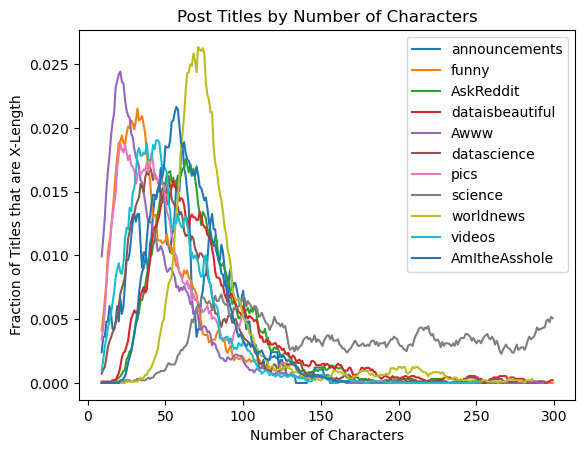

In [14]:
# Define the window size for the moving average
window_size = 10

# Initialize an empty dictionary to store the data
data = {}

# Iterate over the top_subreddits
for subreddit in top_subreddits:
    # Get the titles for the subreddit
    titles = df_raw[df_raw['subreddit'] == subreddit]['title']
    # Get the number of characters in the titles
    num_chars = [len(title) for title in titles]
    # Get the percentage of titles for the subreddit with a specific number of characters
    percentages = []
    for i in range(max(num_chars)):
        percentages.append(num_chars.count(i)/len(num_chars))
    # Apply moving average
    percentages_smooth = pd.Series(percentages).rolling(window_size).mean()
    # Add the data to the dictionary
    data[subreddit] = percentages_smooth

# Plot the data
for subreddit, percentages in data.items():
    plt.plot(range(len(percentages)), percentages, label=subreddit)

# Add labels and title
plt.xlabel("Number of Characters")
plt.ylabel("Fraction of Titles that are X-Length")
plt.title("Post Titles by Number of Characters")
plt.legend()

# Show
plt.show()


Looking at the same graph for character length is a little bit more revealing, but not much.

## Contains Specific Expressions

Let's look at specific expressions such as "aita", "data", "[oc]", and "?" to see what they tell us about the specific subreddit.
We can also check to see if there are emojis.

Let's now find a list of all the words used more than 100 times. And we'll do the same key_words thing

In [15]:
from collections import Counter

# Create a list of all words in the title column
lower_df = df.copy()
lower_df['title'] = lower_df['title'].apply(lambda x: x.lower())

all_words = ' '.join(lower_df['title']).split()
# Create a Counter object to count the occurrences of each word
word_count = Counter(all_words)
# Create a list of words that appear more than 100 times
frequent_words = [word for word, count in word_count.items() if count > 100]
# Print the list of frequent words
print(frequent_words)



['this', 'is', 'for', 'new', 'and', 'to', 'the', 'on', 'an', 'a', 'you', 'can', 'with', 'our', 'from', 'who', 'into', 'how', 'your', 'some', 'have', 'of', 'i', 'us', 'are', 'we', 'had', 'what', 'as', 'in', 'about', 'more', 'people', 'will', 'like', 'has', 'not', 'my', 'could', 'be', 'it', 'so', 'was', 'but', 'time', 'all', 'that', 'year', 'just', 'out', 'their', 'up', 'by', 'at', '-', 'when', "what's", 'data', 'than', 'if', 'over', 'do', 'one', '[oc]', 'he', 'most', 'were', 'found', 'first', 'his', 'after', 'best', 'did', 'me', 'her', 'or', 'science', 'get', 'friend', 'would', 'they', 'she', 'years', 'which', 'telling', '|', 'says', 'ukraine', '2022', 'study', 'wanting', 'aita', 'wibta']


In [16]:
conditions = {}

def contains(key):
    def foo(sentence):
        return (key in sentence.split())

    return foo


def add_contains_key(key):
    conditions['contains "' + key + '"'] = contains(key)


for key in frequent_words:
    add_contains_key(key)

table = pd.DataFrame(columns=['Condition', '% Correct', 'Total Affected'])

for key, val in conditions.items():
    filter = lower_df['title'].apply(val)
    temp_df = lower_df[filter]
    total = len(temp_df)
    if total == 0: break

    cor = []
    for subreddit in top_subreddits:
        cor.append(len(temp_df[temp_df['subreddit'] == subreddit]) / total)

    correct_percent = max(cor)

    table = pd.concat(
        [table, pd.DataFrame({'Condition': [key], '% Correct': [correct_percent], 'Total Affected': [total]})],
        ignore_index=True)

table

,Condition,% Correct,Total Affected
0,"contains ""this""",0.256466,464
1,"contains ""is""",0.329439,856
2,"contains ""for""",0.463696,1818
3,"contains ""new""",0.395639,321
4,"contains ""and""",0.341118,1413
...,...,...,...
88,"contains ""2022""",0.879032,124
89,"contains ""study""",0.930736,231
90,"contains ""wanting""",0.980000,100
91,"contains ""aita""",1.000000,795


Remember that there are 11 subreddits to choose from, so any guess better than 10% is still good.
This tells me that a simple Bag-of-Words algorithm will probably not do too bad.

Let's also see if specific characters can be useful in determining which subreddit a post title belongs to.


In [17]:
# Create a list of all characters in the title column


all_characters = ''.join(df['title'])
total_chars = len(all_characters)

In [18]:

# Create a Counter object to count the occurrences of each word
character_count = Counter(all_characters)
# Create a list of words that appear more than 100 times
infrequent_chars = [char for char, count in character_count.items() if ((count < total_chars/100) & (count > 10))]
# Print the list of frequent words
print(infrequent_chars)

['T', 'b', '.', 'F', ',', 'R', 'I', 'v', '/', 'C', 'O', 'V', 'D', 'S', 'G', 'A', '’', '(', ')', 'N', 'k', 'U', 'P', '—', '1', '0', '%', '-', '9', 'W', 'H', 'M', 'x', 'L', '…', '2', 'E', "'", '!', '3', 'B', ':', 'z', 'q', '8', 'Y', 'Q', '?', 'J', '7', 'j', '6', ';', '#', 'K', '"', '5', '█', '[', ']', '“', '”', '4', '🥰', '$', '‘', '️', '*', 'X', '&', 'Z', '🤣', '+', '_', '|', '😂', 'é', '=', '–', '❤', '😍', '♥', '\u200d', 'ا']


In [19]:

conditions = {}


def contains(key):
    def foo(sentence):
        return (key in sentence)

    return foo


def add_contains_key(key):
    conditions['contains "' + key + '"'] = contains(key)


for key in infrequent_chars:
    add_contains_key(key)

table = pd.DataFrame(columns=['Condition', '% Correct', 'Total Affected'])

for key, val in conditions.items():
    filter = df['title'].apply(val)
    temp_df =df[filter]
    total = len(temp_df)
    if total == 0: break

    cor = []
    for subreddit in top_subreddits:
        cor.append(len(temp_df[temp_df['subreddit'] == subreddit]) / total)

    correct_percent = max(cor)

    table = pd.concat(
        [table, pd.DataFrame({'Condition': [key], '% Correct': [correct_percent], 'Total Affected': [total]})],
        ignore_index=True)

table

,Condition,% Correct,Total Affected
0,"contains ""T""",0.350707,2686
1,"contains ""b""",0.173427,4117
2,"contains "".""",0.223154,1788
3,"contains ""F""",0.160188,849
4,"contains "",""",0.256524,1801
...,...,...,...
79,"contains ""❤""",0.918919,37
80,"contains ""😍""",0.947368,38
81,"contains ""♥""",1.000000,11
82,"contains ""‍""",0.800000,10


Surprisingly even a simple character analysis seems like it could be useful in determining which subreddit.

# 5: Naive Solution

The easiest Naive Solution would be to use Bag-of-Words to vectorize each post title, then a dicision tree based algorithm to classify it. We will then compare the Individual Recall and Accuracy scores to Human Guesses. Since we're using a fairly simple model we are going to retrain the model 20 times to get an accurate measure of the standard deviation of the metric scores. This will allow us to plot the error bars on the bar chart. Note that the Human Guesses won't have error bars because I refuse to manually classify the data 20 times.

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm

naive_results = {}
for sub in top_subreddits:
    naive_results[sub] = []
naive_results['Total'] = []

for i in tqdm(range(20)):

    # Split the dataframe into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(df['title'], df['subreddit'], test_size=0.2, random_state=i)


    # Vectorize the post titles using Bag-of-Words
    vectorizer = CountVectorizer()
    X_train_vectors = vectorizer.fit_transform(X_train)
    X_test_vectors = vectorizer.transform(X_test)

    # Train a random forest model to classify each title to its corresponding subreddit
    clf = RandomForestClassifier()
    clf.fit(X_train_vectors, y_train)

    # Make predictions on the test set
    y_pred = clf.predict(X_test_vectors)
    classification_rep = classification_report(y_test, y_pred, output_dict=True)

    temp_total = 0
    for sub in top_subreddits:
        naive_results[sub].append(classification_rep[sub]['recall'])
        temp_total+=classification_rep[sub]['recall']
    naive_results['Total'].append(temp_total/len(top_subreddits))


100%|██████████| 20/20 [01:44<00:00,  5.21s/it]


In [21]:
naive_results_mean = {}
naive_results_std = {}
for key, val in naive_results.items():
    naive_results_mean[key] = np.mean(val)
    naive_results_std[key] = np.std(val)
naive_results_95_error = list(map(lambda x: 2*x, naive_results_std.values()))

naive_bar_data = naive_results_mean

human_bar_data = {}
for sub in top_subreddits:
    filter1 = human['actual'] == sub
    filter2 = human['actual'] == human['prediction']
    #human_prediction_data.loc[sub] = len(human[filter1 & filter2])/20
    human_bar_data[sub] = len(human[filter1 & filter2])/20

human_bar_data['Total'] = sum(list(human_bar_data.values()))/len(top_subreddits)


#naive_bar_data = list(naive_results_mean.values())

In [26]:
# Save the Data for Later

with open("naive_results.pkl", 'wb') as f:
    pkl.dump(naive_bar_data, f)


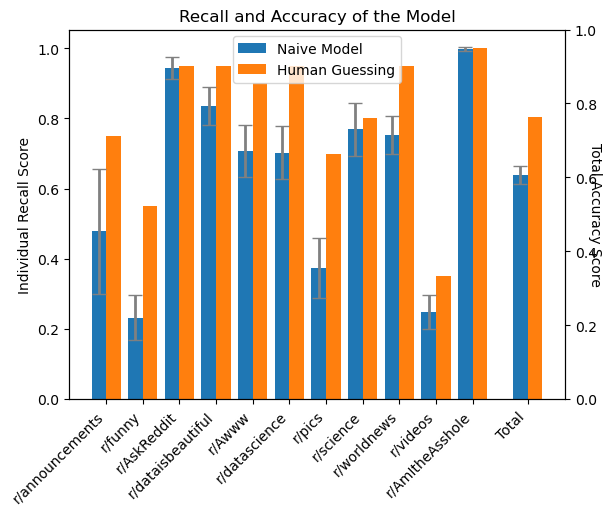

In [22]:
# Create a Bar Chart

categories = list(naive_bar_data.keys())
for i, cat in list(enumerate(categories))[:-1]:
    categories[i] = 'r/'+cat

xticks = list(range(len(categories)))
xticks[-1]+=.5
xticks = np.array(xticks)

bar_width = 0.4

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.bar(xticks - 0.2, naive_bar_data.values(), bar_width, label = 'Naive Model')
ax1.bar(xticks + 0.2, human_bar_data.values(), bar_width, label = 'Human Guessing')

# Add error bars to the 'Naive Model' set of bars
#Naive_Error = [0.1, 0.15, 0.2, 0.05, 0.1, .1, .3, .05, .2, .1, .11, .15] # Example values
ax1.errorbar(xticks - 0.2, naive_bar_data.values(), yerr=naive_results_95_error, fmt='none', ecolor='gray', elinewidth=2, capsize=5)


ax1.set_xticks(xticks)
ax1.set_xticklabels(categories, rotation=45, ha='right')

plt.xlabel("Subreddits")
ax1.set_ylabel("Individual Recall Score")
ax2.set_ylabel("Total Accuracy Score", rotation = -90)
plt.title("Recall and Accuracy of the Model")
ax1.legend()
plt.show()






Another piece of useful information might be to know how subreddits are being missclassified. In the following directed graph each arrow represents a set of missclassifications. The source of the arrow is the actual subreddit and the target of the arrow is the miss-predicted subreddit. The size of the arrow shows how many missclassifications of that type.

For example, a large arrow from r/funny to r/Awww means that a lot of post titles which were actually in r/funny we missclassified as belonging to r/Awww, while a the lack of an arrow from r/AmItheAsshole to r/AskReddit means that no post title belonging to r/AmItheAsshole was ever missclassified as belonging to r/AskReddit.

In [23]:
output = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
output['correct'] = output['Actual'] == output['Prediction']
output

,Actual,Prediction,correct
id,,,
10p6398,videos,videos,True
10jj0j8,science,datascience,False
10q7cev,AskReddit,AskReddit,True
10q7vp5,AskReddit,AskReddit,True
zlniy0,dataisbeautiful,pics,False
...,...,...,...
10p8daw,AmItheAsshole,AmItheAsshole,True
10o40wu,worldnews,worldnews,True
10q8zh0,science,science,True


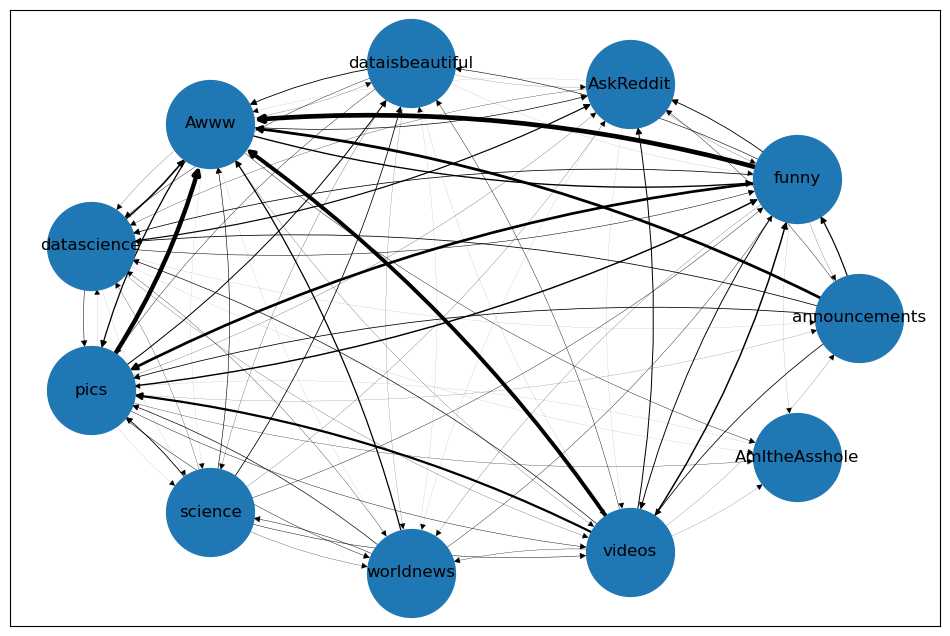

In [24]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed graph
G = nx.DiGraph()

scale = 10

# Add the nodes to the graph
for sub in top_subreddits:
    G.add_node(sub)

# Add the edges to the graph, along with their weights
misguesses = {}
for source in top_subreddits:
    total = len(output[output['Actual'] == source])
    for target in top_subreddits:
        if source != target:
            misguessed = len(output[(output['Actual'] == source) & (output['Prediction'] == target)])
            misguesses[(source, target)] = misguessed / total
            if misguessed > .01:
                G.add_edge(source, target, weight=scale * misguessed / total)

# Draw the graph
pos = nx.circular_layout(G)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# Create a figure that is 8 inches wide and 6 inches tall
plt.figure(figsize=(12, 8))

edge_width = [d['weight'] for (u, v, d) in G.edges(data=True)]
#nx.draw_networkx_edges(G, pos, width=edge_width, edge_color='black', arrows=True, arrowsize=20)

nx.draw_networkx(G, pos, width=edge_width, connectionstyle="arc3,rad=0.1", node_size=4000)
#nx.draw(G, pos=pos)
plt.show()

# 6: Establish Goals

Let us compare the Recall and Accuracy scores of the Naive Model and Human Guessing. We realise that Human Guessing is substantially better in all but two subreddits, r/AmItheAsshole and r/AskReddit, where the model preforms nearly perfectly. There are 4 subreddits that will cause considerable trouble, r/videos, r/pics, r/funny, and r/announcements. These subreddits will most likely be the most difficult to improve performance on. The other subreddits seem do-able.

This project is a success if we have a model that meets the following criteria:
- Accuracy score > .7
- Minimum Subreddit Recall Score > .5
- Maximum Subreddit Recall Score > .99

The most difficult part of this goal will be raising the Minimum Recall Score above .5. Specifically the subreddits r/videos, r/pics, and r/funny will cause the most problems.

# 7: Speculation on Further Improvements

There are many immediately obvious things I can do to improve results:
- Include auxiliary information such as "title length" and "number of emojis" and "number of capital letters"
- Add a part_of_speach tokenizer
- More sophisticated embedding algorithms like Doc-2-Vec
- Compare other classification algorithms like XGBoost or Support Vector Machines
- Include more advanced information like "number of miss-spellings" and "sentiment"
- More Data

However a "winning" solution will most likely be an ensample approach.
1. Set of simple rules to classify and eliminate r/AmItheAsshole.
2. A model which classifies the other "easy" subreddits or r/DataisBeautiful and r/worldnews
3. A model which classifies r/Awww because that would eliminate a lot of the false classification
4. The rest.
